![cover](NNT_header.png)

In [ ]:
!pip install pandas_datareader==0.10.0

import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings 
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

     |████████████████████████████████| 109 kB 6.4 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


#### Нейросеть GRU. Расчет прогноза изменения цены на X дней вперед
Версия beta 0.6.5. ////////////  Время вычисления прогноза с настройками по умолчанию 1-2 минуты. 
В случае зависания или вылета программы, просто перезагрузите страницу.

In [ ]:
tiker = 'ZC=F'

- За сколько лет скачивать данные котировок? По умолчанию: 2

In [ ]:
y1 = 2

In [ ]:
n_d = 365 * int(y1)

dataset_start = datetime.now() - timedelta(days=n_d)

- До какой даты получать данные? Если пусто: Сегодня. Формат: ГГГГ-ММ-ДД

In [ ]:
end=datetime.now()
end

datetime.datetime(2021, 11, 20, 23, 32, 42, 29651)

In [ ]:
end = '2021-11-12'

- Сколько лет учитывать для обучения? По умолчанию: 1

In [ ]:
y2 = 1

In [ ]:
n_d2 = 365 * int(y2)
calculate_start = datetime.now() - timedelta(days=n_d2)

In [ ]:
print(dataset_start)
print(end)
print(calculate_start)

2019-11-21 23:32:42.018822
2021-11-12
2020-11-20 23:32:42.086864


In [ ]:
def collect_data(Symbol, start_date):
    stock_data = DataReader(Symbol, data_source='yahoo', start=start_date, end=end)
    return stock_data    

#Test the function
data = collect_data(tiker, dataset_start)

In [ ]:
print("Total number of days: ",data.shape[0])
print("Total number of fields: ",data.shape[1])
print("Null values:", data.isnull().values.sum())
print("NA values:", data.isna().values.any())
# convert date field from string to Date format 
data = data.reset_index()
data['Date'] = pd.to_datetime(data.Date)


Total number of days:  494
Total number of fields:  6
Null values: 0
NA values: False


In [ ]:
data

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-11-22,370.25,367.50,368.00,368.75,228112.0,368.75
1,2019-11-25,372.75,368.25,368.75,370.50,199301.0,370.50
2,2019-11-26,370.50,367.00,369.75,367.50,207678.0,367.50
3,2019-11-27,368.75,362.25,367.25,362.75,163967.0,362.75
4,2019-12-02,375.50,371.00,371.75,373.50,6280.0,373.50
...,...,...,...,...,...,...,...
489,2021-11-08,554.75,549.50,552.00,551.50,166976.0,551.50
490,2021-11-09,564.00,547.75,551.00,554.75,246899.0,554.75
491,2021-11-10,571.75,555.00,555.50,569.25,209267.0,569.25
492,2021-11-11,579.00,566.00,567.75,569.50,264523.0,569.50


In [ ]:
closedf = data[['Date','Close']]

### С какой даты учитывать прогноз?

In [ ]:
closedf = closedf[closedf['Date'] > calculate_start]
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  244


In [ ]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))

In [ ]:
# делим датасет на train и test
training_size = int(len(closedf)*0.60)
test_size = len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# Модель

In [ ]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
batch = 32

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=batch,verbose=1)

Epoch 1/100
5/5 [==============================] - 13s 1s/step - loss: 0.2792 - val_loss: 0.0400
Epoch 2/100
5/5 [==============================] - 0s 62ms/step - loss: 0.1101 - val_loss: 0.0023
Epoch 3/100
5/5 [==============================] - 0s 49ms/step - loss: 0.0224 - val_loss: 0.0481
Epoch 4/100
5/5 [==============================] - 0s 56ms/step - loss: 0.0427 - val_loss: 0.0220
Epoch 5/100
5/5 [==============================] - 0s 73ms/step - loss: 0.0209 - val_loss: 0.0030
Epoch 6/100
5/5 [==============================] - 0s 61ms/step - loss: 0.0187 - val_loss: 0.0020
Epoch 7/100
5/5 [==============================] - 0s 74ms/step - loss: 0.0188 - val_loss: 0.0050
Epoch 8/100
5/5 [==============================] - 0s 61ms/step - loss: 0.0157 - val_loss: 0.0105
Epoch 9/100
5/5 [==============================] - 0s 84ms/step - loss: 0.0147 - val_loss: 0.0103
Epoch 10/100
5/5 [==============================] - 1s 106ms/step - loss: 0.0162 - val_loss: 0.0044
Epoch 11/100
5/5 [=

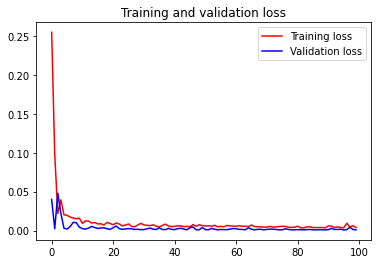

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((130, 1), (82, 1))

In [ ]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


Train predicted data:  (244, 1)
Test predicted data:  (244, 1)


- На сколько дней вперед строить прогноз? По умолчанию: 7

In [ ]:
p_days = 7

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = p_days
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)

In [ ]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

Pr = -1-(p_days)
P = round(lstmdf[Pr], 2)
X = round(lstmdf[-1], 2)
proc = round((X - P) / (P / 100), 2)
print('Последняя известная цена на дату ', end, ':  ', P,  sep='')
print('Прогноз на ', p_days, ' дней: ', X, ' или ', proc, '%',  sep='' )

fig = px.line(lstmdf,labels={'value': 'цена','index': 'дни'})
fig.update_layout(title_text=tiker, showlegend=False)
fig.update_xaxes(rangeslider_visible=True)
#fig.add_vline(x=261-p_days, line_width=1, line_dash="dash", line_color="red")
fig.show()

Последняя известная цена на дату 2021-11-12:  577.25
Прогноз на 7 дней: 557.27 или -3.46%


### Показатели модели

In [ ]:
print('Evaluation metrices RMSE, MSE and MAE Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.')
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))

print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("-------------------------------------------------------------------------------------")
print('The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.')
print('Чем ближе к 1 - тем лучше!')
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))
print('------------')
print("R2 score for regression R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.")
print('Чем ближе к 1 - тем лучше!')
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))
print('------------')
print('Чем ближе к 0 - тем лучше!')
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Evaluation metrices RMSE, MSE and MAE Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.
Train data RMSE:  19.143577270447263
Train data MSE:  366.4765507095851
Train data MAE:  14.390174278846153
Test data RMSE:  10.807153905285835
Test data MSE:  116.79457553253486
Test data MAE:  8.566683141196647
-------------------------------------------------------------------------------------
The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.
Чем ближе к 1 - тем лучше!
Train data explained variance regression score: 0.9618629688954493
Test data explained variance regression score: 0.7164149090318677
------------
R2 score for 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4443513c-0bf1-4763-8feb-cfacec61e611' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>